In [1]:
!pip install numpy
!pip install opencv-python



In [2]:
import numpy as np
import math

def create_scene():
    width = 32
    height = 16

    num_vertices = (height - 2) * width + 2
    num_triangles = (height - 2) * (width - 1) * 2

    index_buffer = np.zeros((3 * num_triangles,), dtype=int)
    vertices = np.zeros((num_vertices, 3), dtype=float)

    t = 0
    for j in range(1, height - 1):
        for i in range(width):
            theta = j / (height - 1) * math.pi
            phi = i / (width - 1) * math.pi * 2

            x = math.sin(theta) * math.cos(phi)
            y = math.cos(theta)
            z = -math.sin(theta) * math.sin(phi)

            vertices[t] = (x, y, z)
            t += 1

    vertices[t] = (0, 1, 0)
    t += 1
    vertices[t] = (0, -1, 0)
    t += 1

    t = 0
    for j in range(height - 3):
        for i in range(width - 1):
            index_buffer[t:t+6] = [j * width + i, (j + 1) * width + (i + 1), j * width + (i + 1),
                                   j * width + i, (j + 1) * width + i, (j + 1) * width + (i + 1)]
            t += 6
    for i in range(width - 1):
        index_buffer[t:t+6] = [(height-2) * width, i, i + 1,
                               (height-2) * width + 1, (height-3) * width + (i + 1), (height-3) * width + i]
        t += 6

    return vertices, index_buffer


In [3]:
!pip install matplotlib

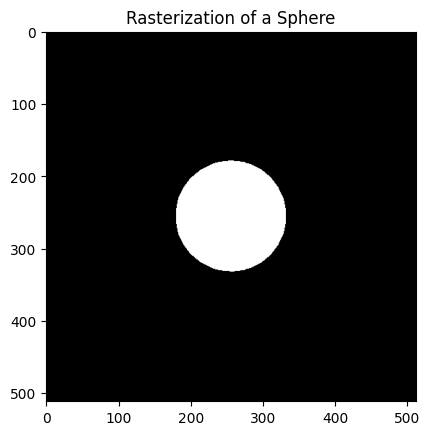

In [4]:
import cv2 as cv
from matplotlib import pyplot as plt

sphere_vertices, triangle_indices = create_scene()

scale_factor = 2
scale_matrix = np.eye(4) * scale_factor
scale_matrix[3, 3] = 1

translate_distance = -7
translation_matrix = np.eye(4)
translation_matrix[:3, 3] = [0, 0, translate_distance]

combined_transform = translation_matrix @ scale_matrix

camera_matrix = np.eye(4)

near_clip = 0.1
far_clip = 1000
left, right, bottom, top = -0.1, 0.1, -0.1, 0.1

perspective_matrix = np.array([
    [2 * near_clip / (right - left), 0, (right + left) / (right - left), 0],
    [0, 2 * near_clip / (top - bottom), (top + bottom) / (top - bottom), 0],
    [0, 0, -(far_clip + near_clip) / (far_clip - near_clip), -2 * far_clip * near_clip / (far_clip - near_clip)],
    [0, 0, -1, 0]
])

# 변환 적용
vertices_with_ones = np.hstack((sphere_vertices, np.ones((sphere_vertices.shape[0], 1))))
transformed_vertices = combined_transform @ vertices_with_ones.T
camera_transformed_vertices = camera_matrix @ transformed_vertices
projected_vertices_homogeneous = perspective_matrix @ camera_transformed_vertices
projected_vertices = projected_vertices_homogeneous[:3] / projected_vertices_homogeneous[3]

window_width, window_height = 512, 512
viewport_transform = np.array([
    [window_width / 2, 0, 0, window_width / 2],
    [0, window_height / 2, 0, window_height / 2],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

image = np.zeros((window_height, window_width, 3), dtype=np.uint8)
for triangle in triangle_indices.reshape(-1, 3):
    triangle_points = viewport_transform @ np.vstack((projected_vertices[:, triangle], np.ones(3)))
    triangle_points = triangle_points[:2].T.astype(int)
    cv.fillConvexPoly(image, triangle_points, (255, 255, 255))

image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title('Rasterization of a Sphere')
plt.show()
